#Mount Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#Import Packages

In [ ]:
#Data handling
import pandas as pd
import numpy as np
from scipy import stats
#Train test split
from sklearn.model_selection import train_test_split
#Deep learning algorithm
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Performance evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Load dataset

In [ ]:
#Read the dataset
df = pd.read_csv('/content/gdrive/MyDrive/data.csv')

#Target labels
labels = {'Normal':0, 'Seizure':1}

#Pre-Processing

##Normalization

In [ ]:
#Normalize signals from all channels
df['FP1-F7'] = df['FP1-F7'] / df['FP1-F7'].max()
df['F7-T7'] = df['F7-T7'] / df['F7-T7'].max()
df['T7-P7'] = df['T7-P7'] / df['T7-P7'].max()
df['P7-O1'] = df['P7-O1'] / df['P7-O1'].max()
df['FP1-F3'] = df['P7-O1'] / df['FP1-F3'].max()
df['F3-C3'] = df['F3-C3'] / df['F3-C3'].max()
df['C3-P3'] = df['C3-P3'] / df['C3-P3'].max()
df['P3-O1'] = df['P3-O1'] / df['P3-O1'].max()
df['FP2-F4'] = df['FP2-F4'] / df['FP2-F4'].max()
df['F4-C4'] = df['F4-C4'] / df['F4-C4'].max()
df['C4-P4'] = df['C4-P4'] / df['C4-P4'].max()
df['P4-O2'] = df['P4-O2'] / df['P4-O2'].max()
df['FP2-F8'] = df['FP2-F8'] / df['FP2-F8'].max()
df['F8-T8'] = df['F8-T8'] / df['F8-T8'].max()
df['T8-P8'] = df['T8-P8'] / df['T8-P8'].max()
df['P8-O2'] = df['P8-O2'] / df['P8-O2'].max()
df['FZ-CZ'] = df['FZ-CZ'] / df['FZ-CZ'].max()
df['CZ-PZ'] = df['CZ-PZ'] / df['CZ-PZ'].max()

#Round the numbers upto 4 decimal place
df = df.round(4)

##Windowing

In [ ]:
#Function to segment the sequences
def window_labels_creation(d_frame, window, step, column_label):

  #Total number of channels
  num_feat = 18
  #Empty lists to store segments and corresponding labels
  windows  = []
  labels   = []

  #Loop over the dataframe
  for i in range(0, len(d_frame) - window, step):
    #Get values equal to window from each channel
    x1 = d_frame['FP1-F7'].values[i: i + window]
    x2 = d_frame['F7-T7'].values[i: i + window]
    x3 = d_frame['T7-P7'].values[i: i + window]
    x4 = d_frame['P7-O1'].values[i: i + window]
    x5 = d_frame['FP1-F3'].values[i: i + window]
    x6 = d_frame['F3-C3'].values[i: i + window]
    x7 = d_frame['C3-P3'].values[i: i + window]
    x8 = d_frame['P3-O1'].values[i: i + window]
    x9 = d_frame['FP2-F4'].values[i: i + window]
    x10 = d_frame['F4-C4'].values[i: i + window]
    x11 = d_frame['C4-P4'].values[i: i + window]
    x12 = d_frame['P4-O2'].values[i: i + window]
    x13 = d_frame['FP2-F8'].values[i: i + window]
    x14 = d_frame['F8-T8'].values[i: i + window]
    x15 = d_frame['T8-P8'].values[i: i + window]
    x16 = d_frame['P8-O2'].values[i: i + window]
    x17 = d_frame['FZ-CZ'].values[i: i + window]
    x18 = d_frame['CZ-PZ'].values[i: i + window]

    #Get corresponding label
    label = stats.mode(d_frame[column_label][i: i + window])[0][0]
    #Append the segments and labels to the created lists
    windows.append([x1, x2, x3,x4, x5, x6,x7, x8, x9,x10, x11, x12,x13, x14, x15,x16, x17, x18])
    labels.append(label)

  #Convert the lists into numpy arrays
  reshaped_windows = np.asarray(windows, dtype= np.float32).reshape(-1, window, num_feat)
  labels = np.asarray(labels)

  return reshaped_windows, labels

#Segment both seizure and non-seizure sequences
#Non seizure windows (Under sampling)
reshaped_windows1, labels1 = window_labels_creation(df[df['seizure']==0.0], 512, 11264, 'seizure')
#Seizure windows     (Oversampling using overlapping)
reshaped_windows2, labels2 = window_labels_creation(df[df['seizure']==1.0], 512, 128, 'seizure')

#Stack the results together
X = np.vstack((reshaped_windows1,reshaped_windows2)).astype('float32')
Y = np.vstack((labels1.reshape(-1,1),labels2.reshape(-1,1))).astype('float32')

##Train/Test Split

In [ ]:
#Create train/test split with 80/20 ratio
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle = True, random_state=4)

#Model Design

In [ ]:
#Channels and window length
n_features = x_train.shape[2]
Time_window = 512

#Create sequential object
model = Sequential()

#CNN Layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(Time_window,n_features)))

#LSTM Layers
model.add(Bidirectional(LSTM(32, return_sequences=False)))

#DNN layers
model.add(Dense(64, activation='relu'))

#Output layer
model.add(Dense(1, activation='sigmoid'))

#Compile model with loss function and optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 510, 32)           1760      
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22,625
Trainable params: 22,625
Non-trainable params: 0
_________________________________________________________________


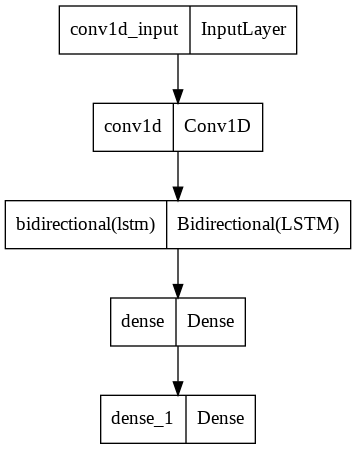

In [ ]:
#Print model summary
model.summary()

#Plot model
plot_model(model)

#Model training

In [ ]:
#Batch size and epochs
Batch_size = 64
Epochs = 100

#Model training
model_hist = model.fit(x_train, y_train, validation_data=(x_test,y_test), 
                    epochs=Epochs, batch_size=Batch_size, verbose=1)

Epoch 1/100
28/28 [==============================] - 5s 68ms/step - loss: 0.6902 - accuracy: 0.5417 - val_loss: 0.6834 - val_accuracy: 0.5896
Epoch 2/100
28/28 [==============================] - 1s 36ms/step - loss: 0.6645 - accuracy: 0.5876 - val_loss: 0.6567 - val_accuracy: 0.5692
Epoch 3/100
28/28 [==============================] - 1s 36ms/step - loss: 0.6487 - accuracy: 0.5933 - val_loss: 0.6347 - val_accuracy: 0.6553
Epoch 4/100
28/28 [==============================] - 1s 36ms/step - loss: 0.6203 - accuracy: 0.6398 - val_loss: 0.5820 - val_accuracy: 0.6939
Epoch 5/100
28/28 [==============================] - 1s 37ms/step - loss: 0.5965 - accuracy: 0.6756 - val_loss: 0.6177 - val_accuracy: 0.6395
Epoch 6/100
28/28 [==============================] - 1s 36ms/step - loss: 0.6053 - accuracy: 0.6841 - val_loss: 0.5634 - val_accuracy: 0.7551
Epoch 7/100
28/28 [==============================] - 1s 37ms/step - loss: 0.5966 - accuracy: 0.6625 - val_loss: 0.6141 - val_accuracy: 0.6440
Epoch 

In [ ]:
#Prediction from the model
pred_prob = model.predict(x_test)
pred_labels = np.squeeze(pred_prob >0.5).astype(int)

14/14 [==============================] - 1s 22ms/step


#Evaluation

##Loss and Accuracy

Text(0.5, 1.0, 'Training and validation accuracy')

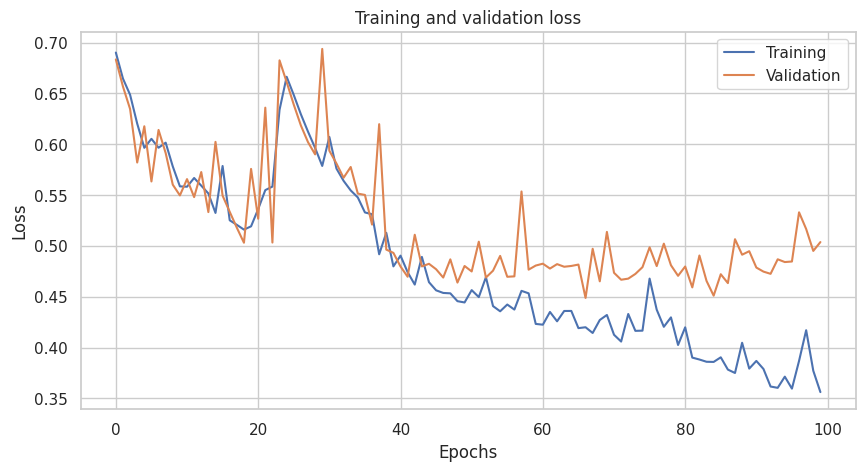

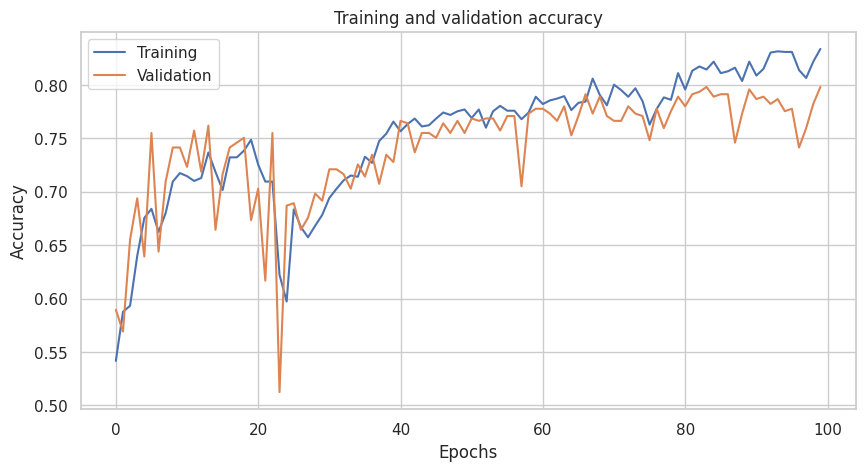

In [ ]:
#Plot loss of the model vs epochs
plt.figure(figsize=(10,5),dpi=100)
sns.set_theme(style='whitegrid')
plt.plot(range(Epochs),model_hist.history['loss']);
plt.plot(range(Epochs),model_hist.history['val_loss']);
#Label the plot
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and validation loss")

#Plot accuracy of the model vs epochs
plt.figure(figsize=(10,5),dpi=100)
plt.plot(range(Epochs),model_hist.history['accuracy']);
plt.plot(range(Epochs),model_hist.history['val_accuracy']);
#Label the figure
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")

##Classification report

In [ ]:
#Classification report
print(classification_report(y_test, pred_labels, target_names=[l for l in list(labels.keys())]))

              precision    recall  f1-score   support

      Normal       0.83      0.76      0.79       222
     Seizure       0.77      0.84      0.81       219

    accuracy                           0.80       441
   macro avg       0.80      0.80      0.80       441
weighted avg       0.80      0.80      0.80       441



##Confusion matrix

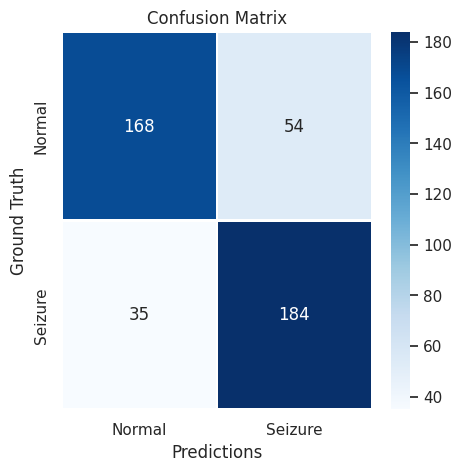

In [ ]:
#Plot confusion matrix
def plot_confusion_matrix(validations, predictions):
  #Calculate confusion matrix
  matrix = confusion_matrix(validations, predictions)
  #Plot the matrix
  plt.figure(figsize=(5, 5), dpi=100)
  sns.heatmap(matrix,
              cmap='Blues',
              linecolor='white',
              linewidths=1,
              xticklabels=list(labels.keys()),
              yticklabels=list(labels.keys()),
              annot=True,
              fmt='d')
  #Label the figure
  plt.title('Confusion Matrix')
  plt.ylabel('Ground Truth')
  plt.xlabel('Predictions')

#Call the function
plot_confusion_matrix(y_test, pred_labels)

##ROC Curve

ANN AUC:  0.8622732321362458


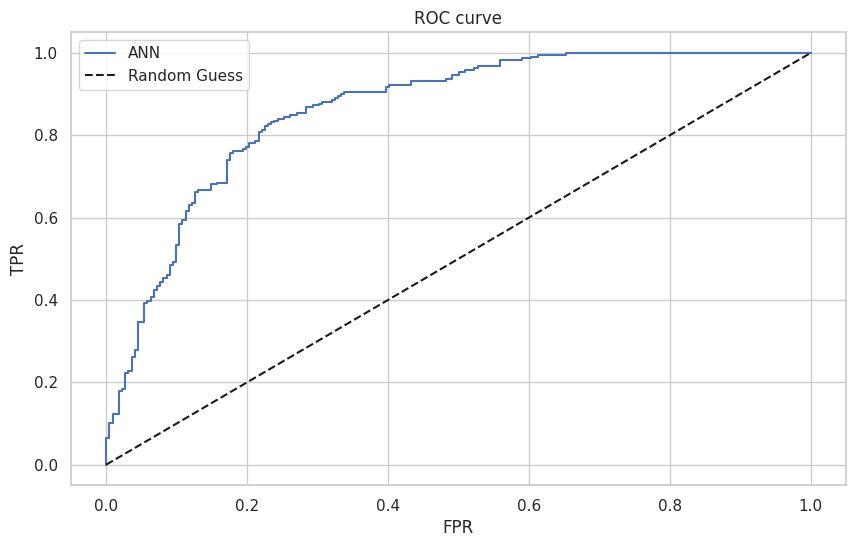

In [ ]:
#Calculate ROC and AUC scores
ann_fpr, ann_tpr, ann_thres = roc_curve(y_test, pred_prob)
ann_auc = roc_auc_score(y_test, pred_prob)

#Plot ROC
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(ann_fpr, ann_tpr, label='ANN')
plt.plot([0,1],[0,1], 'k--', label='Random Guess')

#Label the figure
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="best")
plt.title("ROC curve")

#AUC score
print("ANN AUC: ", ann_auc)

#Save the predictions

In [ ]:
np.save('ANN.npy', pred_prob)
np.save('y_test_dl.npy', y_test)